# Compressive ISM

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn
from numpy.random import poisson
import os
import imageio
import math


import brighteyes_ism.analysis.APR_lib as apr
import brighteyes_ism.analysis.Deconv_lib as deconv
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.analysis.FocusISM_lib as fism

import brighteyes_ism.simulation.PSF_sim as ism
import brighteyes_ism.simulation.Tubulin_sim as simTub

## Point-spread functions

### Simulation settings and SPAD array parameters

In [41]:
N = 3 # number of detector elements in each dimension
center = math.ceil(N*N/2) # Middle element
Nx = 512 # number of pixels of the simulation space. (Ground Truth)
pxsizex = 25 # pixel size of the simulation space (nm) 
pxdim = 50e3 # detector element size in real space (nm)
pxpitch = 75e3 # detector element pitch in real space (nm)
## Difference betweeb detector element size and pitch?
M = 500 # total magnification of the optical system (e.g. 100x objective follewd by 5x telescope)

#%% PSF simulation 2D

exPar = ism.simSettings()
exPar.wl = 640 # excitation wavelength (nm)
exPar.mask_sampl = 31

emPar = exPar.copy()
emPar.wl = 660 # emission wavelength (nm)

z_shift = 0 #nm

### Generate excitation PSF and detection PSFs

In [13]:
PSF, detPSF, exPSF = ism.SPAD_PSF_2D(N, Nx, pxpitch, pxdim, pxsizex, M, exPar, emPar, z_shift=z_shift)

PSF /= np.max(PSF)

# Why two times calculating field near the focus

Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████████| 512/512 [00:43<00:00, 11.66it/s]


Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████████| 512/512 [00:44<00:00, 11.59it/s]


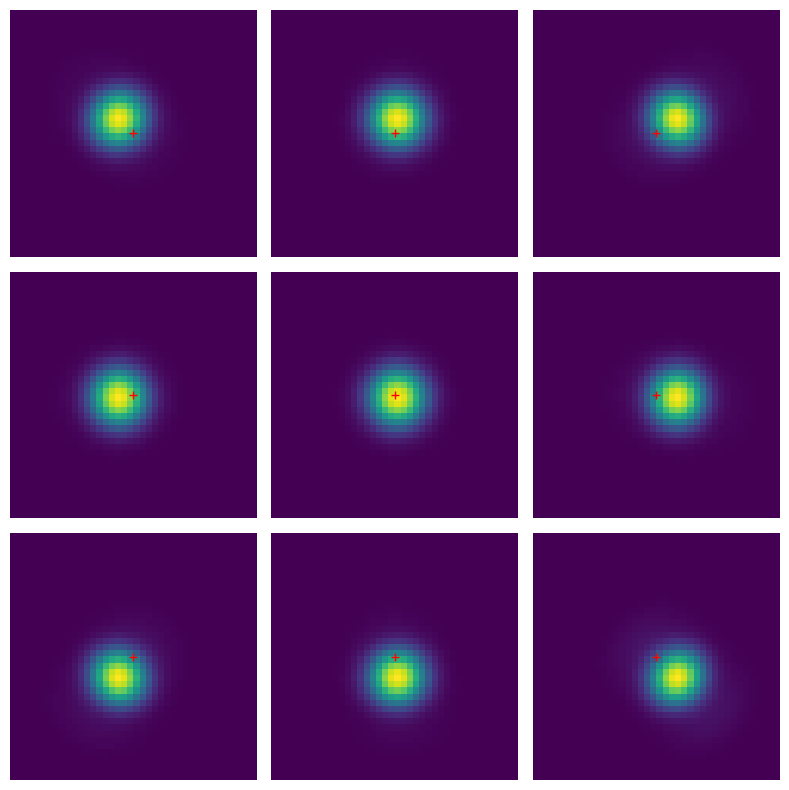

In [4]:
fig = plt.figure(figsize=(8,8))
for i in range(N*N):
    ax = fig.add_subplot(N, N, i+1)
    ax.imshow(PSF[:,:,i], extent = [-(Nx//2*pxsizex), Nx//2*pxsizex, -(Nx//2*pxsizex), Nx//2*pxsizex])
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    ax.plot(0,0,'+r')
    plt.axis('off')

plt.tight_layout()

(-0.5, 2.5, 2.5, -0.5)

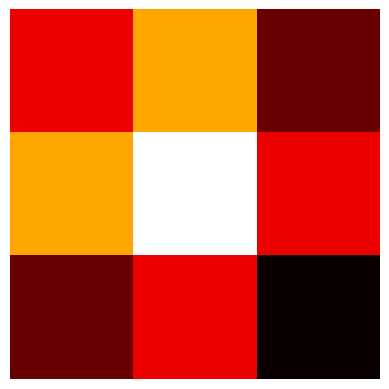

In [5]:
fingerprint = ism.Fingerprint(PSF)
plt.figure();
plt.imshow(fingerprint, cmap='hot')
plt.axis('off')

### Find shift vectors

Text(0, 0.5, 'Shift$_y$ (nm)')

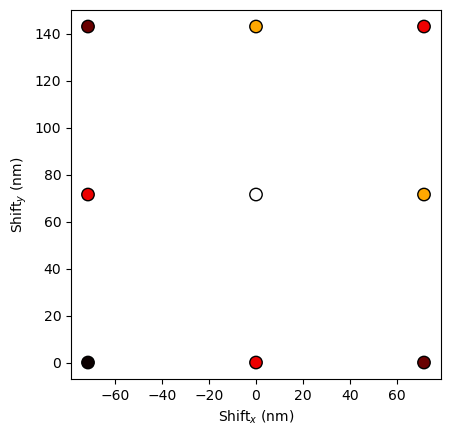

In [6]:
shift = apr.ShiftVectors(PSF, 100, center)[0]
shift *= pxsizex

plt.figure()
plt.scatter(shift[:,0], shift[:,1], s = 80, c = fingerprint, edgecolors = 'black', cmap = 'hot')
plt.gca().set_aspect('equal', 'box')

plt.xlabel(r'Shift$_x$ (nm)')
plt.ylabel(r'Shift$_y$ (nm)')

## Tubulin

### Simulate ground truth

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.90s/it]

tubulin filament out of the boundaries [112.91735698] [-0.07834989] 512


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


tubulin filament out of the boundaries [512.00613437] [167.50362068] 512


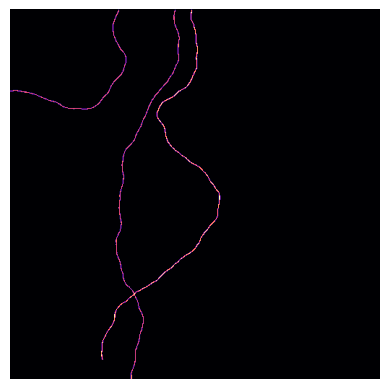

In [19]:
#%% Generate tubulin

tubulin = simTub.tubSettings()
tubulin.xy_pixel_size = pxsizex
tubulin.xy_dimension = Nx
tubulin.xz_dimension = 1     
tubulin.z_pixel = 1     
tubulin.n_filament = 3
tubulin.radius_filament = pxsizex*0.6
tubulin.intensity_filament = [0.5,0.9]  
phTub = simTub.functionPhTub(tubulin)
plt.figure()
plt.imshow(phTub[:,:,0],cmap='magma')
plt.axis('off')

TubDec = phTub[:,:,0]

# Specify the file path and name
file_path = 'data/'
file_name = 'GroundTruth.png'

# Save the image as a PNG file
imageio.imwrite(file_path + file_name, phTub[:,:,0])


### Simulate detected images

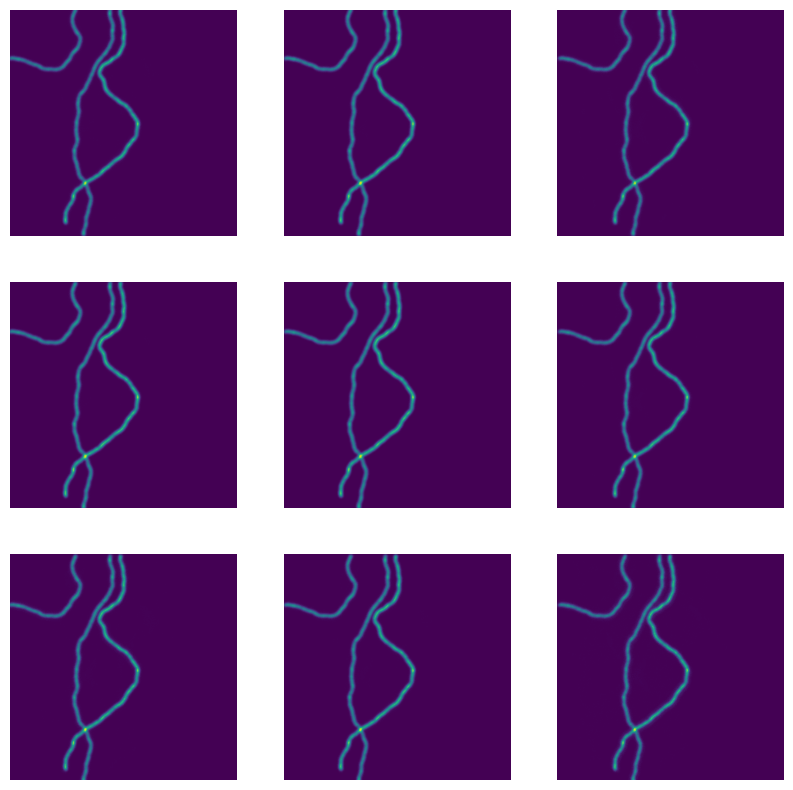

In [20]:
#%% Convolve tubulin with psf

img = np.empty(PSF.shape)

for n in range(N**2):
    img[:, :, n] = sgn.convolve(TubDec, PSF[:, :, n] ,mode = 'same')

#%% Convert to photons and add Poisson noise

img *= 1e2
img = np.uint16(img)

img_1 = poisson(img)
img_2 = poisson(img)

fig = plt.figure(figsize=(10,10))
for i in range(N*N):
    ax = fig.add_subplot(N, N, i+1)
    ax.imshow(img_1[:,:,i])
    plt.axis('off')
    
#%% Save each image of the detector   
for i in range(img_1.shape[2]):
    fig, axs = plt.subplots(figsize=(10, 5))
    axs.imshow(img_1[:,:,i])
    axs.axis('off')
    plt.savefig(f"data\detector_{i+1}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)


## Sample the Data (Matlab)

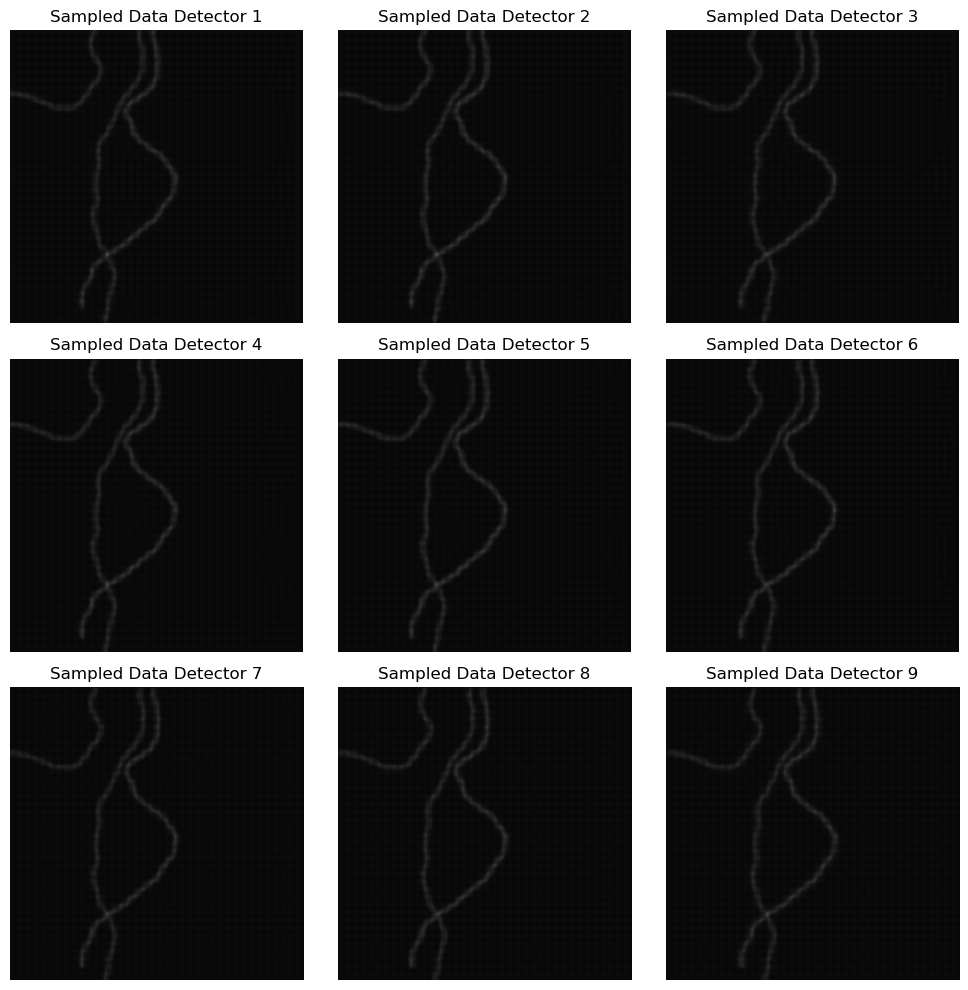

In [22]:
folder_path = "data"
image_prefix = "measure_"

fig, axes = plt.subplots(N, N, figsize=(10, 10))

# Loop over the image indices and plot them in a 3 by 3 grid
for i, ax in enumerate(axes.flatten()):
    image_filename = image_prefix + str(i + 1) + ".png"
    image_path = os.path.join(folder_path, image_filename)

    # Read the image and display it
    image = plt.imread(image_path)
    ax.imshow(image, cmap="gray")
    ax.axis('off')
    ax.set_title("Sampled Data Detector " + str(i + 1))

plt.tight_layout()
plt.show()

## Reconstructed Image (Matlab)

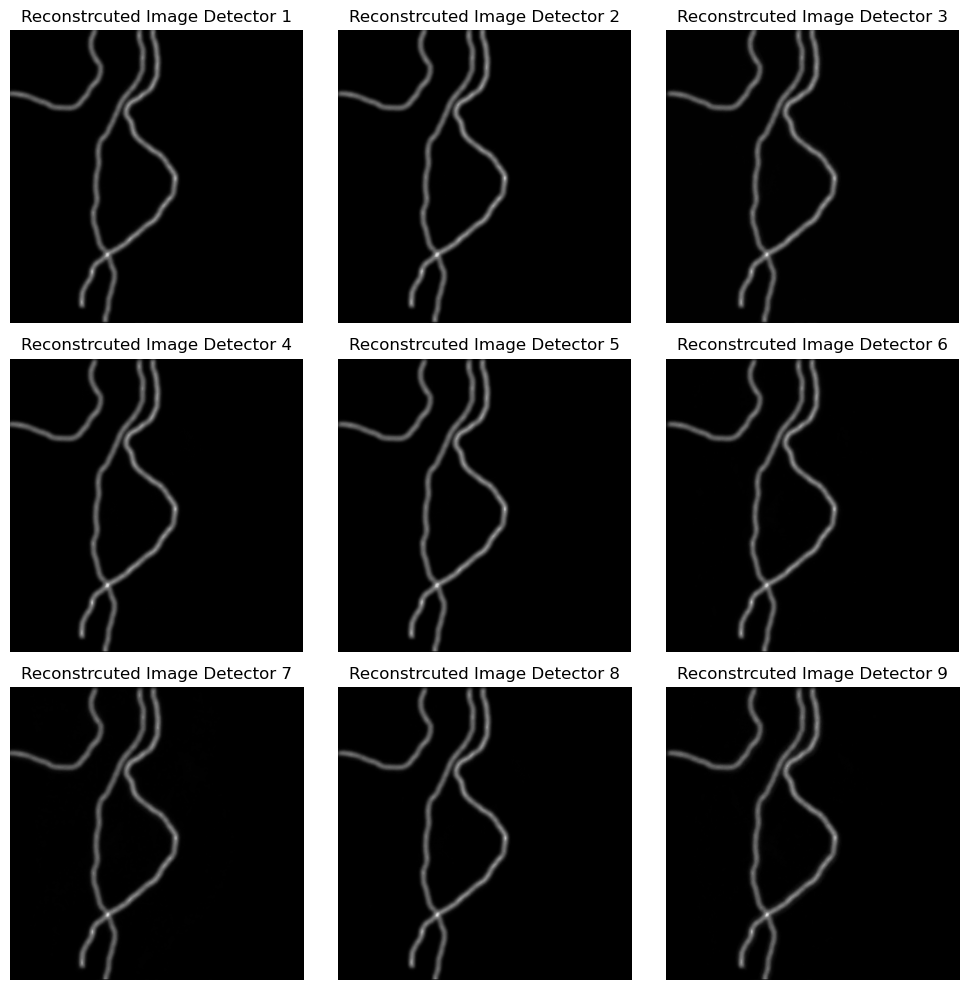

In [23]:
folder_path = "data"
image_prefix = "recon_"

fig, axes = plt.subplots(N, N, figsize=(10, 10))

recon_img = np.empty(PSF.shape)
# Loop over the image indices and plot them in a 3 by 3 grid
for i, ax in enumerate(axes.flatten()):
    image_filename = image_prefix + str(i + 1) + ".png"
    image_path = os.path.join(folder_path, image_filename)

    # Read the image and display it
    image = plt.imread(image_path)
    recon_img[:, :, n] = image;
    ax.imshow(image, cmap="gray")
    ax.axis('off')
    ax.set_title("Reconstrcuted Image Detector " + str(i + 1))

plt.tight_layout()
plt.show()

### Confocal vs ISM vs Compressive-ISM

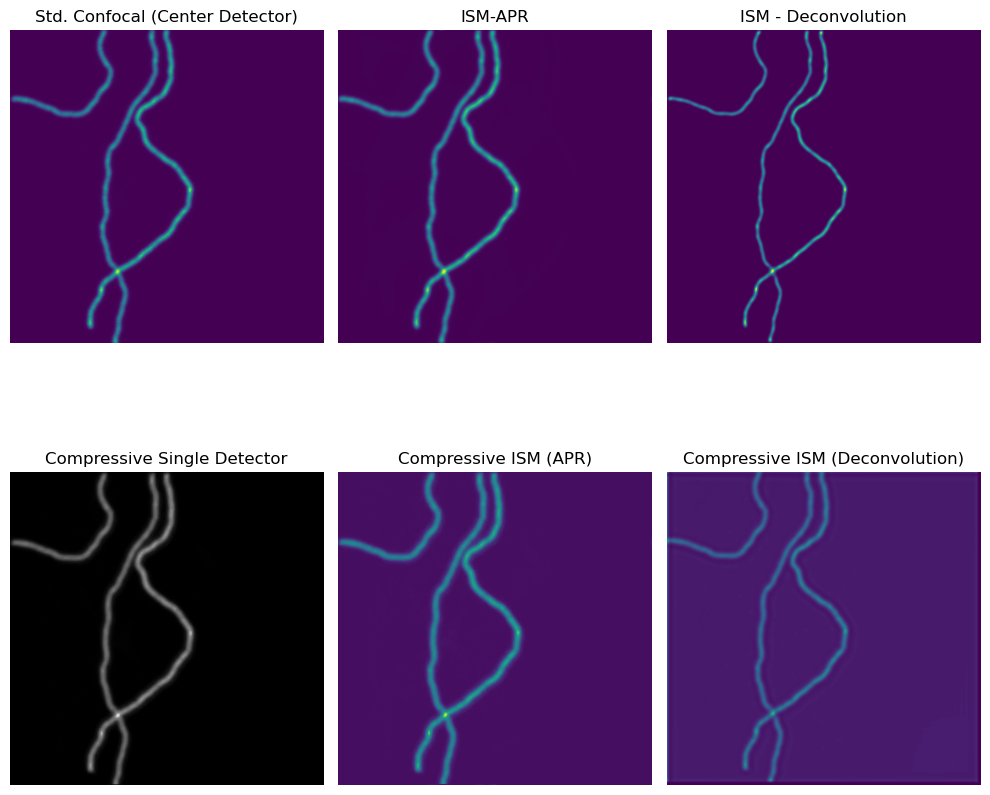

In [57]:
img_sum_1 = img_1[:,:,center]
center_compression = recon_img[:,:,center]

img_sum_2 = np.sum(img_2, axis = -1)

usf = 100
ref = N**2//2

shift_1, img_ism_1 = apr.APR(img_1, usf, ref, pxsize = pxsizex)
shift_2, img_ism_2 = apr.APR(img_2, usf, ref, pxsize = pxsizex)

img_ism_sum_1 = np.sum(img_ism_1, axis=-1)
img_ism_sum_2 = np.sum(img_ism_2, axis=-1)


shift_3, img_ism_recon_1 = apr.APR(recon_img, usf, ref, pxsize = pxsizex)
compressive_ism = np.sum(img_ism_recon_1, axis=-1)


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(img_sum_1)
#ax.imshow(image, cmap="gray")
ax.set_title('Std. Confocal (Center Detector)')
plt.axis('off')


ax = fig.add_subplot(2, 3, 4)
ax.imshow(recon_img[:,:,center])
ax.imshow(image, cmap="gray")
ax.set_title('Compressive Single Detector')
plt.axis('off')


ax = fig.add_subplot(2, 3, 2)
ax.imshow(img_ism_sum_2)
#ax.imshow(image, cmap="gray")
ax.set_title('ISM-APR')
plt.axis('off')


ax = fig.add_subplot(2, 3, 5)
ax.imshow(compressive_ism)
#ax.imshow(image, cmap="gray")
ax.set_title('Compressive ISM (APR)')
plt.axis('off')

img_deconv1 = deconv.MultiImg_RL_FFT( PSF, img_1, max_iter = 10)

ax = fig.add_subplot(2, 3, 3)
ax.imshow(img_deconv1)
#ax.imshow(image, cmap="gray")
ax.set_title('ISM - Deconvolution')
plt.axis('off')


img_deconv2 = deconv.MultiImg_RL_FFT( PSF, recon_img, max_iter = 10)

ax = fig.add_subplot(2, 3, 6)
ax.imshow(img_deconv2)
#ax.imshow(image, cmap="gray")
ax.set_title('Compressive ISM (Deconvolution)')
plt.axis('off')

plt.tight_layout()